In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn import metrics


In [13]:
# Define the directory where the dataset is located
dataset_dir = '../Data/new_soil_types'

# Define the image size and batch size
image_size = 224  # Standard input size for MobileNet
batch_size = 32

# Define data transformations: resize, random augmentation, and normalization
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])



In [14]:
# Load the dataset using ImageFolder (expects folder structure like: root/class_name/image.jpg)
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

In [15]:
# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')

Training dataset size: 2136
Validation dataset size: 534


In [16]:
# Load MobileNetV2 pre-trained model
model = models.mobilenet_v2(pretrained=True)

# Freeze the layers of the MobileNetV2 model
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match our 5 classes (soil types)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model architecture
print(model)


c:\Users\HP\OneDrive\Desktop\Harvestify\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\OneDrive\Desktop\Harvestify\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100.0%


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        # Calculate training accuracy and loss
        train_accuracy = correct_preds / total_preds * 100
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate validation accuracy and loss
        valid_accuracy = correct_preds / total_preds * 100
        valid_loss = valid_loss / len(valid_loader)

        # Print epoch stats
        print(f"Epoch {epoch+1}/{num_epochs} -> "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        # Save the best model based on validation accuracy
        if valid_accuracy > best_acc:
            best_acc = valid_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    print("Training complete.")
    return model

# Train the model
num_epochs = 10
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)


Epoch 1/10 -> Train Loss: 1.3451, Train Accuracy: 49.16% Valid Loss: 1.0851, Valid Accuracy: 58.99%
Epoch 2/10 -> Train Loss: 1.0454, Train Accuracy: 59.41% Valid Loss: 0.8795, Valid Accuracy: 68.54%
Epoch 3/10 -> Train Loss: 0.8809, Train Accuracy: 68.82% Valid Loss: 0.7531, Valid Accuracy: 76.22%
Epoch 4/10 -> Train Loss: 0.7629, Train Accuracy: 75.33% Valid Loss: 0.6515, Valid Accuracy: 81.46%
Epoch 5/10 -> Train Loss: 0.6801, Train Accuracy: 79.92% Valid Loss: 0.5729, Valid Accuracy: 84.46%
Epoch 6/10 -> Train Loss: 0.6055, Train Accuracy: 83.24% Valid Loss: 0.5201, Valid Accuracy: 88.01%
Epoch 7/10 -> Train Loss: 0.5622, Train Accuracy: 84.27% Valid Loss: 0.4708, Valid Accuracy: 89.51%
Epoch 8/10 -> Train Loss: 0.5287, Train Accuracy: 85.21% Valid Loss: 0.4324, Valid Accuracy: 91.01%
Epoch 9/10 -> Train Loss: 0.4785, Train Accuracy: 87.50% Valid Loss: 0.4007, Valid Accuracy: 91.39%
Epoch 10/10 -> Train Loss: 0.4678, Train Accuracy: 86.84% Valid Loss: 0.3863, Valid Accuracy: 90.82%

Validation Accuracy: 90.64%


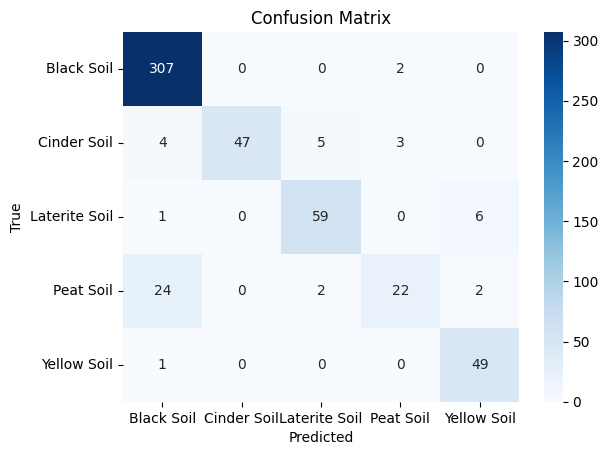

In [18]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the validation set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
pip install utils.soil_model

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement utils.soil_model (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for utils.soil_model
